# Image Scene Classification

In [1]:
#%cd /content/drive/My Drive/data

In [3]:
!pwd

/content/drive/MyDrive/Kaggle


In [4]:
!ls

best_model.h5  best_model.h7  saved_model  seg_test
best_model.h6  kaggle.json    seg_pred	   seg_train


In [ ]:
# import zipfile

# # unzip file
# with zipfile.ZipFile("seg_train.zip", "r") as zip_ref:
#     zip_ref.extractall()

In [5]:
import os
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
print(tensorflow.__version__)
print(np.__version__)

2.8.0
1.21.5


In [ ]:
# !pip install wandb

In [ ]:
# import wandb
# from wandb.keras import WandbCallback

# wandb.login()

In [7]:
config = {
    'IMAGE_WIDTH': 150,
    'IMAGE_HEIGHT': 150,
    'IMAGE_CHANNELS': 3,
    'BATCH_SIZE': 128,
    'NUM_CLASSES': 6,
    'EPOCHS': 200,
    'OPTIMIZER': 'Adam',
    'LOSS': 'categorical_crossentropy',
    'H1_FILTERS': 128,
    'H1_KERNEL_SIZE': (5, 5),
    'H2_FILTERS': 64,
    'H2_KERNEL_SIZE': (3, 3),
    'H3_FILTERS': 32,
    'H3_KERNEL_SIZE': (3, 3),
    'H4_DENSE_UNITS': 256,
    'ES_PATIENCE': 20,
    'MAX_POOLING_POOL_SIZE': (2, 2),
    'DROPOUT_RATE': 0.5,
    'BEST_MODEL': 'best_model_run_5.h5'   
}

In [ ]:
# wandb.init(project="NN", 
#            entity="",
#            name='run_1',
#            config=config)

In [8]:
TRAIN_DATASET_PATH = 'seg_train/seg_train/'

In [9]:
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(TRAIN_DATASET_PATH,
                                                    target_size=(config['IMAGE_WIDTH'], config['IMAGE_HEIGHT']),
                                                    batch_size=config['BATCH_SIZE'],
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training',
                                                    seed=1)

validation_generator = train_datagen.flow_from_directory(TRAIN_DATASET_PATH,
                                                    target_size=(config['IMAGE_WIDTH'], config['IMAGE_HEIGHT']),
                                                    batch_size=config['BATCH_SIZE'],
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    subset='validation',
                                                    seed=1)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


## Class labels

In [10]:
class_labels = {value: key for key, value in train_generator.class_indices.items()}

for key, value in class_labels.items():
    print(f"{key} : {value}")

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


## Training data

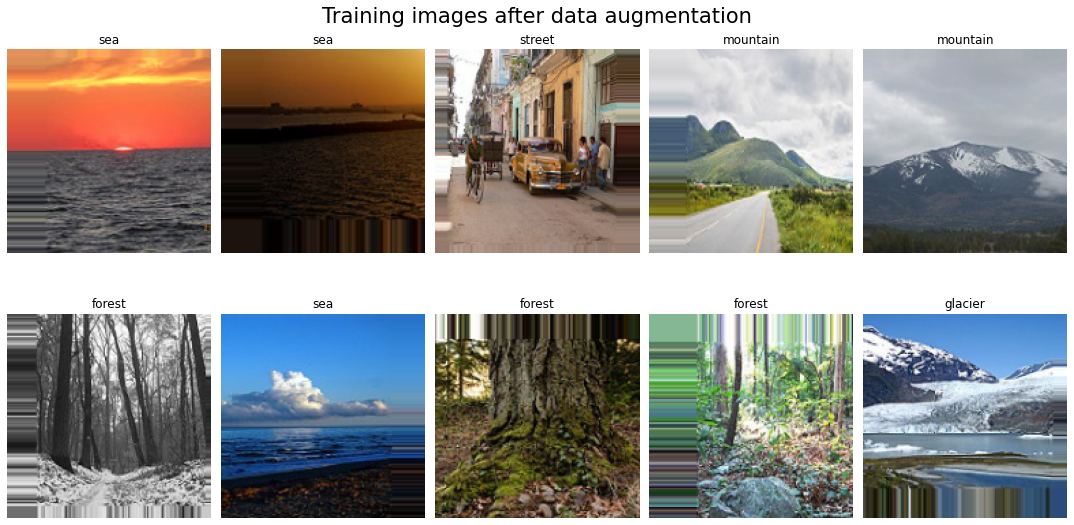

In [11]:
nrows = 2
ncols = 5
class_labels = {value: key for key, value in train_generator.class_indices.items()}
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
idx = 0

for i in range(nrows):
    for j in range(ncols):
        label = class_labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout(True) 
plt.suptitle("Training images after data augmentation", fontsize=21)
plt.show()

## CNN Architecture

In [12]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=config['H1_FILTERS'], kernel_size=config['H1_KERNEL_SIZE'], 
                     input_shape=(config['IMAGE_WIDTH'], config['IMAGE_HEIGHT'], config['IMAGE_CHANNELS']), 
                     padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=config['MAX_POOLING_POOL_SIZE']))

cnn_model.add(Conv2D(filters=config['H2_FILTERS'], kernel_size=config['H2_KERNEL_SIZE'], padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=config['MAX_POOLING_POOL_SIZE']))

cnn_model.add(Conv2D(filters=config['H3_FILTERS'], kernel_size=config['H3_KERNEL_SIZE'], padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=config['MAX_POOLING_POOL_SIZE']))

cnn_model.add(Flatten())
cnn_model.add(Dense(units=config['H4_DENSE_UNITS'], activation='relu'))
cnn_model.add(Dropout(config['DROPOUT_RATE']))

cnn_model.add(Dense(units=config['NUM_CLASSES'], activation ='softmax'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 32)       0

In [13]:
cnn_model.compile(optimizer=config['OPTIMIZER'], loss=config['LOSS'], metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=config['ES_PATIENCE']) 

mc = ModelCheckpoint(config['BEST_MODEL'], monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [14]:
# history = cnn_model.fit(train_generator, 
#                         epochs=config['EPOCHS'], 
#                         validation_data=validation_generator, 
#                         callbacks=[es, mc, WandbCallback()], 
#                         verbose=1,
#                         workers=12)

history = cnn_model.fit(train_generator, 
                        epochs=config['EPOCHS'], 
                        validation_data=validation_generator, 
                        callbacks=[es, mc], 
                        verbose=1,
                        workers=12)

Epoch 1/200
88/88 [==============================] - ETA: 0s - loss: 1.3636 - accuracy: 0.4542
Epoch 1: val_accuracy improved from -inf to 0.53495, saving model to best_model_run_5.h5
88/88 [==============================] - 444s 4s/step - loss: 1.3636 - accuracy: 0.4542 - val_loss: 1.1719 - val_accuracy: 0.5350
Epoch 2/200
88/88 [==============================] - ETA: 0s - loss: 1.1078 - accuracy: 0.5646
Epoch 2: val_accuracy improved from 0.53495 to 0.61377, saving model to best_model_run_5.h5
88/88 [==============================] - 102s 991ms/step - loss: 1.1078 - accuracy: 0.5646 - val_loss: 0.9884 - val_accuracy: 0.6138
Epoch 3/200
88/88 [==============================] - ETA: 0s - loss: 0.9843 - accuracy: 0.6175
Epoch 3: val_accuracy improved from 0.61377 to 0.62161, saving model to best_model_run_5.h5
88/88 [==============================] - 102s 990ms/step - loss: 0.9843 - accuracy: 0.6175 - val_loss: 0.9598 - val_accuracy: 0.6216
Epoch 4/200
88/88 [===========================

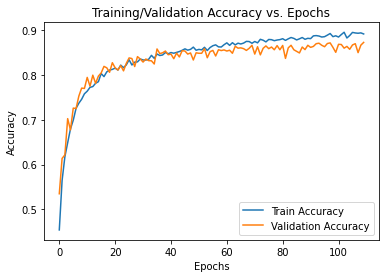

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training/Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
# plt.savefig('image', bbox_inches='tight')
plt.show()

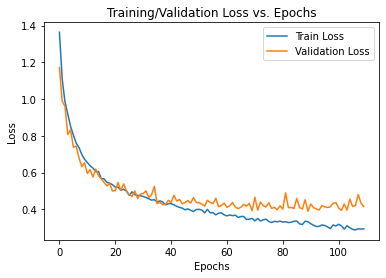

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training/Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
# plt.savefig('image', bbox_inches='tight')
plt.show()

In [ ]:
# wandb.finish()

In [17]:
saved_model = load_model(config['BEST_MODEL'])

## Evaluating model performance using validation dataset 

In [18]:
validation_loss, validation_accuracy = saved_model.evaluate(validation_generator, batch_size=config['BATCH_SIZE'], workers=12)

print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

22/22 [==============================] - 21s 438ms/step - loss: 0.4136 - accuracy: 0.8595
Validation Loss: 0.41360026597976685
Validation Accuracy: 0.85948646068573


In [19]:
val_predictions = saved_model.predict(validation_generator, workers=12)

In [20]:
y_pred = np.argmax(val_predictions, axis=1)
y_true = validation_generator.classes

In [21]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

array([[343,   9,   4,   7,  20,  55],
       [  3, 438,   1,   7,   2,   3],
       [  1,   3, 390,  60,  21,   5],
       [  1,   2,  51, 419,  27,   2],
       [  4,   2,  16,  16, 409,   7],
       [ 31,   6,   4,   4,   8, 423]])

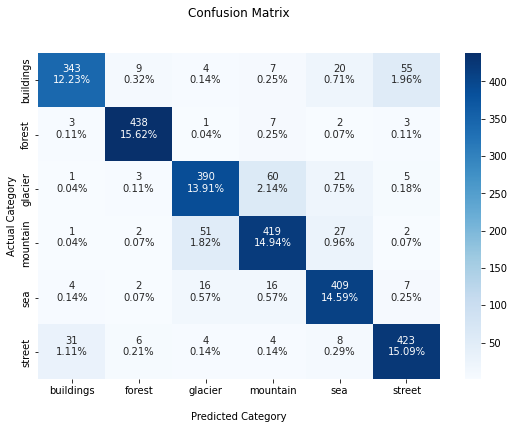

In [22]:
def plot_confusion_matrix(cf_matrix, generator, figsize):
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(config['NUM_CLASSES'], config['NUM_CLASSES'])
    class_labels = {value: key for key, value in generator.class_indices.items()}

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(cf_matrix, annot=labels, xticklabels=class_labels.values(), yticklabels=class_labels.values(), fmt='', cmap='Blues')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category');
    # plt.savefig('image', bbox_inches='tight')
    plt.show()


plot_confusion_matrix(cf_matrix=cf_matrix, 
                      generator=validation_generator, 
                      figsize=(9, 6))

In [23]:
def get_wrong_predictions(y_true, y_pred, generator):
    errors = (y_true - y_pred != 0)
    y_true_errors = y_true[errors]
    y_pred_errors = y_pred[errors]

    image_filenames = generator.filenames
    wrong_predictions_image_filenames = np.asarray(image_filenames)[errors]
    return (y_true_errors, y_pred_errors, wrong_predictions_image_filenames)


y_true_errors, y_pred_errors, wrong_predictions_image_filenames = get_wrong_predictions(y_true, y_pred, validation_generator)

print(f'Number of wrong predictions: {len(wrong_predictions_image_filenames)}')

Number of wrong predictions: 382


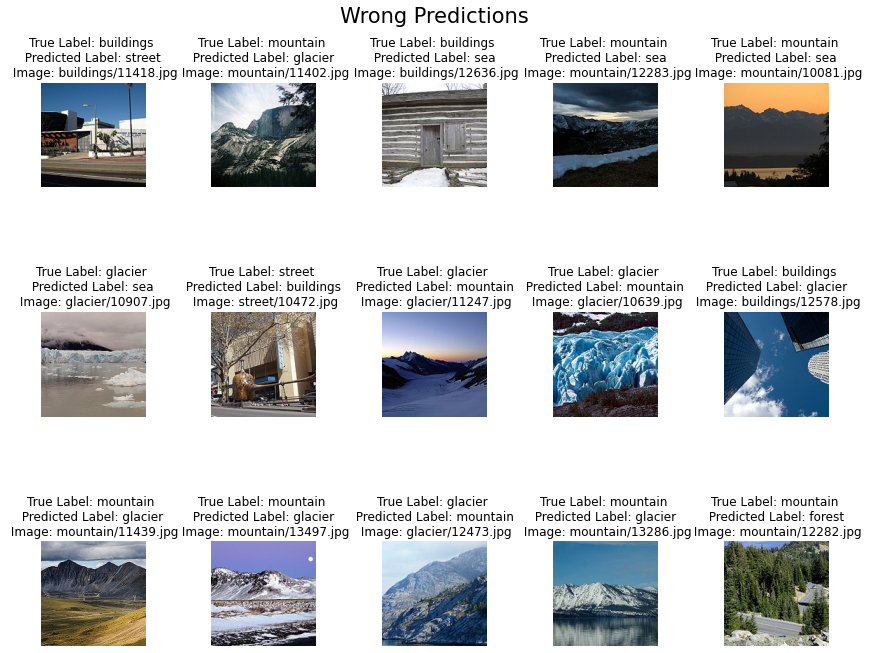

In [24]:
def plot_wrong_predictions(wrong_predictions_image_filenames, y_true_errors, y_pred_errors, dataset_path, generator, nrows, ncols, figsize, random_seed):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    np.random.seed(random_seed)
    max_rand = len(wrong_predictions_image_filenames) - nrows * ncols - 1
    class_labels = {value: key for key, value in generator.class_indices.items()}

    for i in range(nrows):
        for j in range(ncols):
            idx = np.random.randint(0, max_rand)
            true_index = y_true_errors[idx]
            true_label = class_labels[true_index]
            predicted_index = y_pred_errors[idx]
            predicted_label = class_labels[predicted_index]
            ax[i, j].set_title(f'True Label: {true_label} \n Predicted Label: {predicted_label} \n Image: {wrong_predictions_image_filenames[idx]}')
            img_path = os.path.join(dataset_path, wrong_predictions_image_filenames[idx])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            idx += 1

    plt.tight_layout(True) 
    plt.suptitle('Wrong Predictions', fontsize=21)
    # plt.savefig('image', bbox_inches='tight')
    plt.show()


plot_wrong_predictions(wrong_predictions_image_filenames=wrong_predictions_image_filenames,
                       y_true_errors=y_true_errors,
                       y_pred_errors=y_pred_errors,
                       dataset_path=TRAIN_DATASET_PATH, 
                       generator=validation_generator,
                       nrows=3,
                       ncols=5,
                       figsize=(12, 10),
                       random_seed=1)

## Evaluating model performance using test dataset 

In [25]:
TEST_DATASET_PATH = 'seg_test/seg_test/'

In [26]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(TEST_DATASET_PATH,
                                                 batch_size=config['BATCH_SIZE'],
                                                 target_size=(config['IMAGE_WIDTH'], config['IMAGE_HEIGHT']),
                                                 class_mode='categorical',
                                                 shuffle=False,
                                                 seed=1)

Found 3000 images belonging to 6 classes.


In [27]:
test_loss, test_accuracy = saved_model.evaluate(test_generator, batch_size=config['BATCH_SIZE'], workers=12)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

24/24 [==============================] - 87s 4s/step - loss: 0.3821 - accuracy: 0.8783
Test Loss: 0.3821495771408081
Test Accuracy: 0.878333330154419


In [28]:
test_predictions = saved_model.predict(test_generator)

In [29]:
y_pred = np.argmax(test_predictions, axis=1)
y_true = test_generator.classes

In [30]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

array([[367,   2,   2,   5,   6,  55],
       [  2, 467,   0,   2,   2,   1],
       [  3,   3, 456,  65,  20,   6],
       [  7,   3,  61, 426,  26,   2],
       [  7,   5,  13,  18, 461,   6],
       [ 26,   9,   1,   2,   5, 458]])

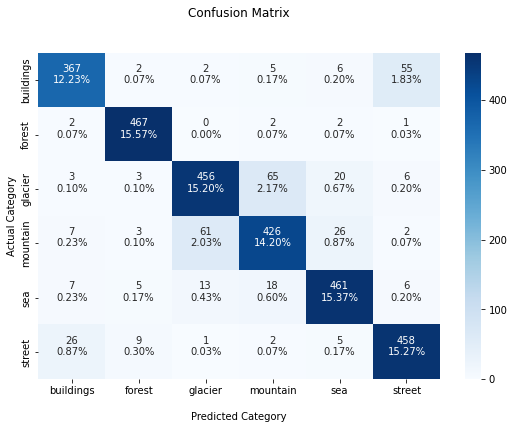

In [31]:
plot_confusion_matrix(cf_matrix=cf_matrix, 
                      generator=test_generator, 
                      figsize=(9, 6))

In [32]:
y_true_errors, y_pred_errors, wrong_predictions_image_filenames = get_wrong_predictions(y_true, y_pred, test_generator)

print(f'Number of wrong predictions: {len(wrong_predictions_image_filenames)}')

Number of wrong predictions: 365


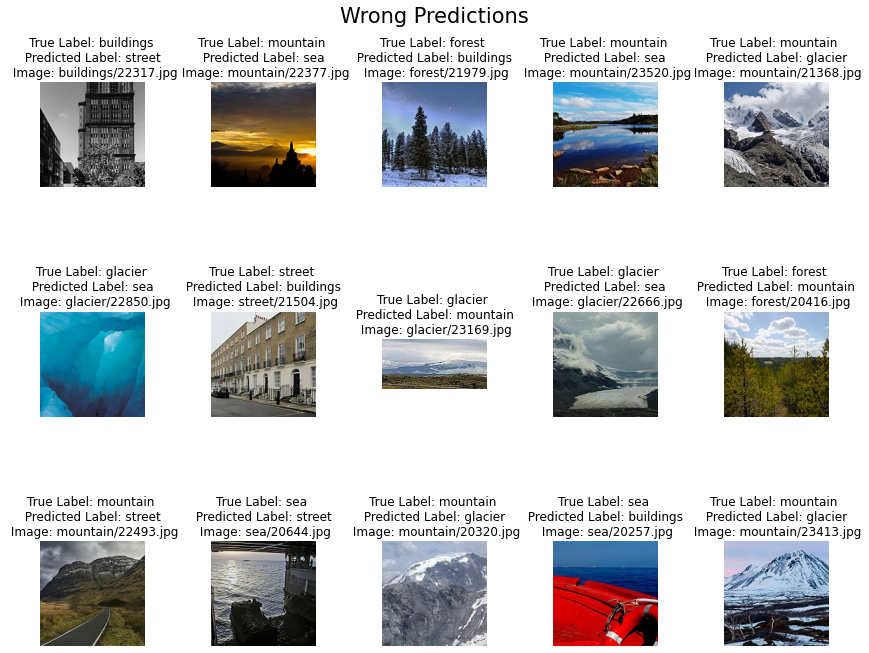

In [33]:
plot_wrong_predictions(wrong_predictions_image_filenames=wrong_predictions_image_filenames,
                       y_true_errors=y_true_errors,
                       y_pred_errors=y_pred_errors,
                       dataset_path=TEST_DATASET_PATH, 
                       generator=test_generator,
                       nrows=3,
                       ncols=5,
                       figsize=(12, 10),
                       random_seed=1)